**Advanced Machine Learning (Semester 1 2023)**
# 6 Recurrent Neural Networks


*N. Hernitschek, 2023*


This Jupyter notebook gives an intro to Recurrent Neural Networks.
Also, here we use a professional neural network library.



---
## Contents
* [Sequential Data](#first-bullet)
* [Recurrent Neural Networks in Keras](#second-bullet)
* [Visualizing Neural Networks](#third-bullet)
* [Preparation for next time](#fourth-bullet)
* [Summary](#fifth-bullet)

## 1. Sequential Data<a class="anchor" id="first-bullet"></a>


Before we start with a `Keras` example, we first should understand the characteristics of sequential data.

Sequential data always have a temporal component. This can either be explicitly defined (like time series data which have one column for time, one column for signal), or implicitly by the order of data (like the words in a sentence or days in a week; also audio data falls into that category).

The **order** is here important, differently to a collection or set.
Any data where the order or sequence is as essential as the data itself is called Sequential Data. 

## 2. Recurrent Neural Networks in Keras<a class="anchor" id="second-bullet"></a>

(adapted from https://www.tensorflow.org/guide/keras/rnn)



Recurrent neural networks (RNN) are a class of neural networks that is powerful for modeling sequence data such as time series or natural language.

Schematically, a RNN layer uses a `for` loop to iterate over the timesteps of a sequence, while maintaining an internal state that encodes information about the timesteps it has seen so far.


<img src="images/many_to_many_unequal_size_rnn.png?modified=12345678" width="300"/>


### 2.1 The Keras API

The Keras RNN API is designed with a focus on:

 *   Ease of use: the built-in `keras.layers.SimpleRNN`, `keras.layers.LSTM`, `keras.layers.GRU` layers enable you to quickly build recurrent models without having to make difficult configuration choices:
    
 `keras.layers.SimpleRNN`, a fully-connected RNN where the output from previous timestep is to be fed to next timestep.


`keras.layers.LSTM`, first proposed in Hochreiter & Schmidhuber, 1997.

`keras.layers.GRU`, first proposed in Cho et al., 2014.
    

 *   Ease of customization: You can also define your own RNN cell layer (the inner part of the for loop) with custom behavior, and use it with the generic `keras.layers.RNN layer` (the for loop itself). This allows you to quickly prototype different research ideas in a flexible way with minimal code.
    
   

Keras Built-in RNNs support a number of useful features:

*   Recurrent dropout, via the dropout and recurrent_dropout arguments
*   Ability to process an input sequence in reverse, via the go_backwards argument
*   Loop unrolling (which can lead to a large speedup when processing short sequences on CPU), via the unroll argument
*   ...and more

### 2.2 Outputs and states

By default, the output of a RNN layer contains a single vector per sample. This vector is the RNN cell output corresponding to the last timestep, containing information about the entire input sequence. The shape of this output is (`batch_size, units`) where units corresponds to the units argument passed to the layer's constructor.

A RNN layer can also return the entire sequence of outputs for each sample (one vector per timestep per sample), if you set `return_sequences=True`. The shape of this output is `(batch_size, timesteps, units)`.

### 2.3 Example: Predicting sunspots

Sunspots are temporary phenomena on the Sun's photosphere that appear as spots darker than the surrounding areas. They are regions of reduced surface temperature caused by concentrations of magnetic field flux that inhibit convection. Sunspots usually appear in pairs of opposite magnetic polarity. Their number varies according to the approximately 11-year solar cycle.


The relative sunspot number is an index of the activity of the entire visible disk of the Sun. It is determined each day without reference to preceding days. It is derived by the equation $R= N_s + 10 \times N_g$, where $N_s$ is the number of spots and $N_g$ the number of groups counted over the entire solar disk.
It can be reported daily or as a monthly average.
We use here the sunspot daa set available at https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv. Similar data sets are available e.g. at
https://www.kaggle.com/datasets/abhinand05/daily-sun-spot-data-1818-to-2019
https://www.kaggle.com/datasets/robervalt/sunspots

The dataset we are using has the wo columns "month" and "sunspots" where the latter is the sunspot number $R$.



Epoch 1/20
187/187 - 2s - loss: 0.1373 - 2s/epoch - 9ms/step
Epoch 2/20
187/187 - 1s - loss: 0.0666 - 587ms/epoch - 3ms/step
Epoch 3/20
187/187 - 1s - loss: 0.0564 - 514ms/epoch - 3ms/step
Epoch 4/20
187/187 - 1s - loss: 0.0531 - 623ms/epoch - 3ms/step
Epoch 5/20
187/187 - 1s - loss: 0.0484 - 594ms/epoch - 3ms/step
Epoch 6/20
187/187 - 1s - loss: 0.0425 - 518ms/epoch - 3ms/step
Epoch 7/20
187/187 - 1s - loss: 0.0393 - 555ms/epoch - 3ms/step
Epoch 8/20
187/187 - 1s - loss: 0.0325 - 726ms/epoch - 4ms/step
Epoch 9/20
187/187 - 1s - loss: 0.0351 - 577ms/epoch - 3ms/step
Epoch 10/20
187/187 - 1s - loss: 0.0263 - 584ms/epoch - 3ms/step
Epoch 11/20
187/187 - 1s - loss: 0.0292 - 578ms/epoch - 3ms/step
Epoch 12/20
187/187 - 1s - loss: 0.0309 - 568ms/epoch - 3ms/step
Epoch 13/20
187/187 - 1s - loss: 0.0268 - 588ms/epoch - 3ms/step
Epoch 14/20
187/187 - 1s - loss: 0.0263 - 564ms/epoch - 3ms/step
Epoch 15/20
187/187 - 1s - loss: 0.0265 - 505ms/epoch - 3ms/step
Epoch 16/20
187/187 - 1s - loss: 0.02

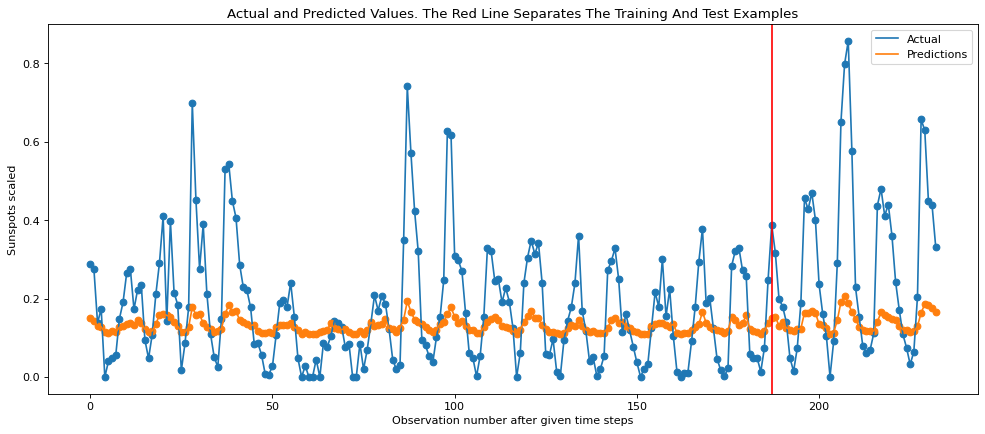

In [45]:
#RNN to predict sunspots

from pandas import read_csv
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt


# Parameter split_percent defines the ratio of training examples
def get_train_test(url, split_percent=0.8):
    df = read_csv(url, usecols=[1], engine='python')
    data = np.array(df.values.astype('float32'))
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data).flatten()
    n = len(data)
    # Point for splitting data into train and test
    split = int(n*split_percent)
    train_data = data[range(split)]
    test_data = data[split:]
    return train_data, test_data, data
 
# Prepare the input X and target Y
# Y is dat at each every time_steps days
def get_XY(dat, time_steps):
    Y_ind = np.arange(time_steps, len(dat), time_steps)
    Y = dat[Y_ind]
    rows_x = len(Y)
    X = dat[range(time_steps*rows_x)]
    X = np.reshape(X, (rows_x, time_steps, 1))    
    return X, Y
 
def create_RNN(hidden_units, dense_units, input_shape, activation):  
    model = Sequential()
    model.add(SimpleRNN(hidden_units, input_shape=input_shape, activation=activation[0]))
    model.add(layers.Dropout(0.2))# added this one
    model.add(Dense(units=dense_units, activation=activation[1]))
    #model.add(Dense(units=dense_units, activation=activation[1])) #new
    model.add(layers.Dropout(0.2))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model
 
def print_error(trainY, testY, train_predict, test_predict):    
    # Error of predictions
    train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
    test_rmse = math.sqrt(mean_squared_error(testY, test_predict))
    # Print RMSE
    print('Train RMSE: %.3f RMSE' % (train_rmse))
    print('Test RMSE: %.3f RMSE' % (test_rmse))    
 
# plot the result

def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.scatter(range(rows), actual)
    plt.scatter(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Observation number after given time steps')
    plt.ylabel('Sunspots scaled')
    plt.title('Actual and Predicted Values. The Red Line Separates The Training And Test Examples')
    
    
##########
# execute code
    
sunspots_url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv'
time_steps = 12 #  use each time_steps points, e.g. time_steps=1 uses all, time_steps=12 uses one each 12 months
# you can change time_steps and see how it influences the prediction
train_data, test_data, data = get_train_test(sunspots_url)
trainX, trainY = get_XY(train_data, time_steps)
testX, testY = get_XY(test_data, time_steps)
    
# try modifying the number of hidden units, dense units and the activation function
model = create_RNN(hidden_units=5, dense_units=1, input_shape=(time_steps,1), 
                   activation=['sigmoid', 'tanh'])

model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)
 
# make predictions
train_predict = model.predict(trainX)
test_predict = model.predict(testX)
 
# Print error
print_error(trainY, testY, train_predict, test_predict)
 
#Plot result
plot_result(trainY, testY, train_predict, test_predict)



**Extensions**

We can experiment with and improve our RNN. Some possible modifications include:

  * Network depth: What happens if we add Recurrent layers? How does that affect training and/or the model’s final performance?
  * Droput: What if we incorporated dropout (e.g. via Dropout layers), which is commonly used to prevent overfitting?
  * Optimizer: We have here used a pretty good default optimizer, the Adam gradient-based optimizer. Keras has many other optimizers you can look into as well.
  * Loss function: you can look into the possible loss functions in the Keras documentation.
  
    
  
**Hint:** To check the effect of the modifications, you can plot the loss vs. epochs.


## 3. Visualizing Neural Networks<a class="anchor" id="third-bullet"></a>

Keras comes with packages that allow for visualizing a neural network model. This doesn't only work with RNN but can be used for any kind of neural network with Keras. (For other neural network libraries, such as PyTorch, packages for visualizing exist as well.)

There exists a variety of packages for this purpose. We're using here two packages:

* `keras.utils.vis_utils` with `graphviz`;
`graphviz` needs to be installed separately (see https://pygraphviz.github.io/documentation/stable/install.html).
* `keras-visualizer` (a good description can be found at https://towardsdatascience.com/visualizing-keras-models-4d0063c8805e).


Another option is `visualkeras`
https://www.analyticsvidhya.com/blog/2022/03/visualize-deep-learning-models-using-visualkeras/



In the following, we first use `keras.utils.vis_utils`:





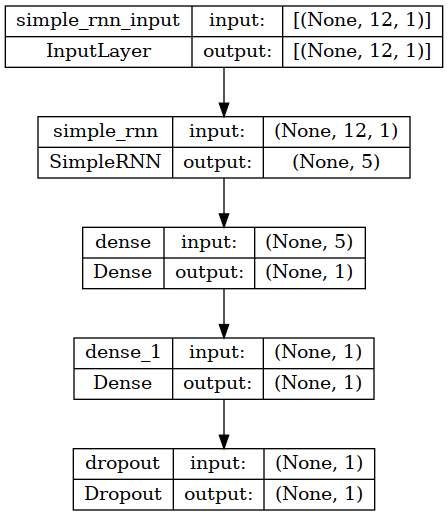

In [11]:
import pydot
import graphviz
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

With the `keras-visualizer`, our RNN looks like that:

In [57]:

from keras_visualizer import visualizer 

model.summary() 
  

visualizer(model, file_name='graph', file_format='png') 
# it doesn't show in the Jupyter notebook but only writes the image to disk
# I don't recommend adding code for displaying the image to Jupyter as Jupyter caches the image 
# and thus doesn't update it


Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_32 (SimpleRNN)   (None, 5)                 35        
                                                                 
 dropout_34 (Dropout)        (None, 5)                 0         
                                                                 
 dense_36 (Dense)            (None, 1)                 6         
                                                                 
 dense_37 (Dense)            (None, 1)                 2         
                                                                 
 dropout_35 (Dropout)        (None, 1)                 0         
                                                                 
Total params: 43
Trainable params: 43
Non-trainable params: 0
_________________________________________________________________


you can also visualize a more complex NN model:

In [62]:
# Building model architecture

from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Activation  

model = Sequential()
model.add(Conv2D(8, (3, 3), padding="same",input_shape=(224,224,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(16, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(32, activation="relu"))
model.add(Dense(10))
model.summary() 
  
visualizer(model, file_name='graph_2', file_format='png') 


Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 224, 224, 8)       224       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 8)        0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 74, 74, 16)        1168      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 37, 37, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 37, 37, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 18, 18, 32)     

**Best Practice Tips**

I generally recommend to always create a summary and a plot of your neural network model in Keras.

Why I recommend this:

* Confirm layer order. It is easy to add layers in the wrong order or to connect them incorrectly. The graph plot can help you confirm that the model is connected the way you intended.
*   Confirm the output shape of each layer. It is common to have problems when defining the shape of input data for complex networks like convolutional and recurrent neural networks. The summary and plot can help you confirm the input shape to the network is as you intended.
*    Confirm parameters. Reviewing the summary can help spot cases of using far more parameters than expected.



## 4. Preparation for next time<a class="anchor" id="fourth-bullet"></a>

Next week you will present your **project idea**. As you have seen so far multiple types of neural networks, try to find the best suitable neural network for your project and include a description (which one would you chose, why) in your presentation.

## 5. Summary <a class="anchor" id="fourth-bullet"></a>

At this point, all of you should have:
* seen how RNN can be used
* visualized neural networks.




